**Exploratory Data Analysis (EDA):**

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
train_df = pd.read_csv('/content/Titanic_train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
missing_values = train_df.isnull().sum()
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


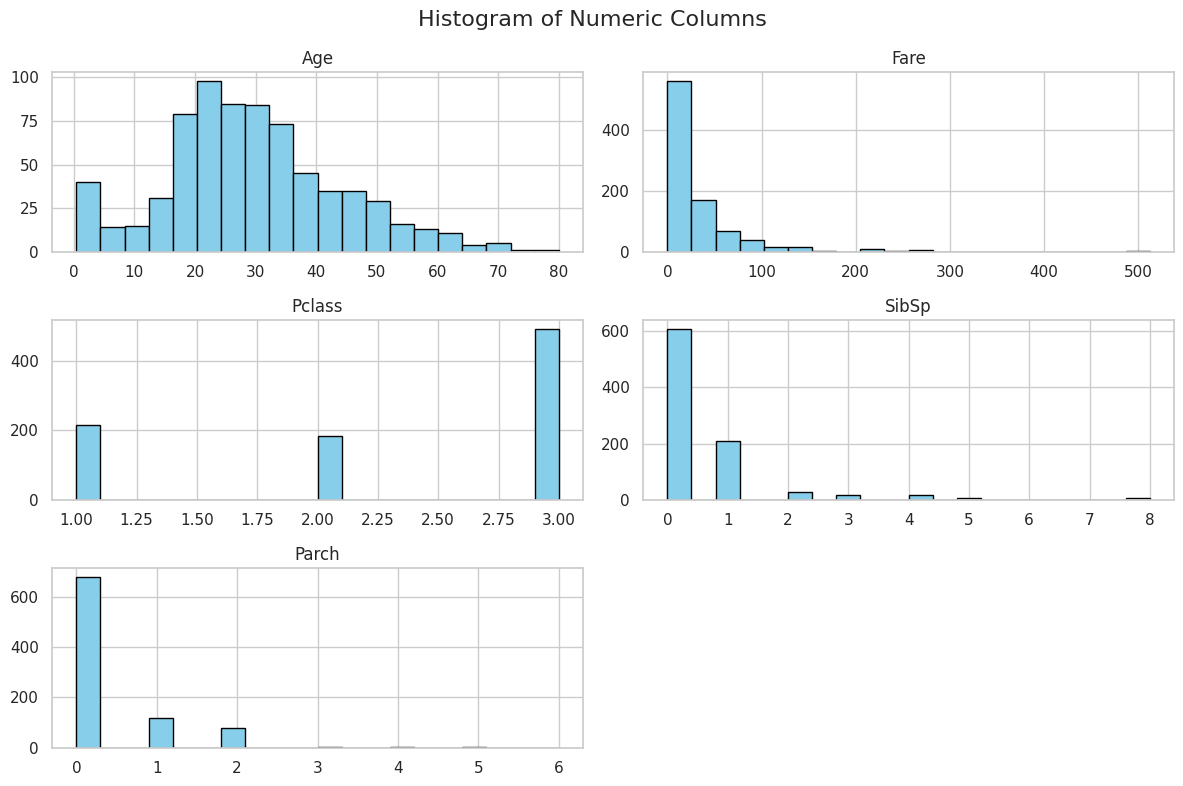

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#Histogram
numeric_cols = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
train_df[numeric_cols].hist(bins=20, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle('Histogram of Numeric Columns', fontsize=16)
plt.tight_layout()
plt.show()



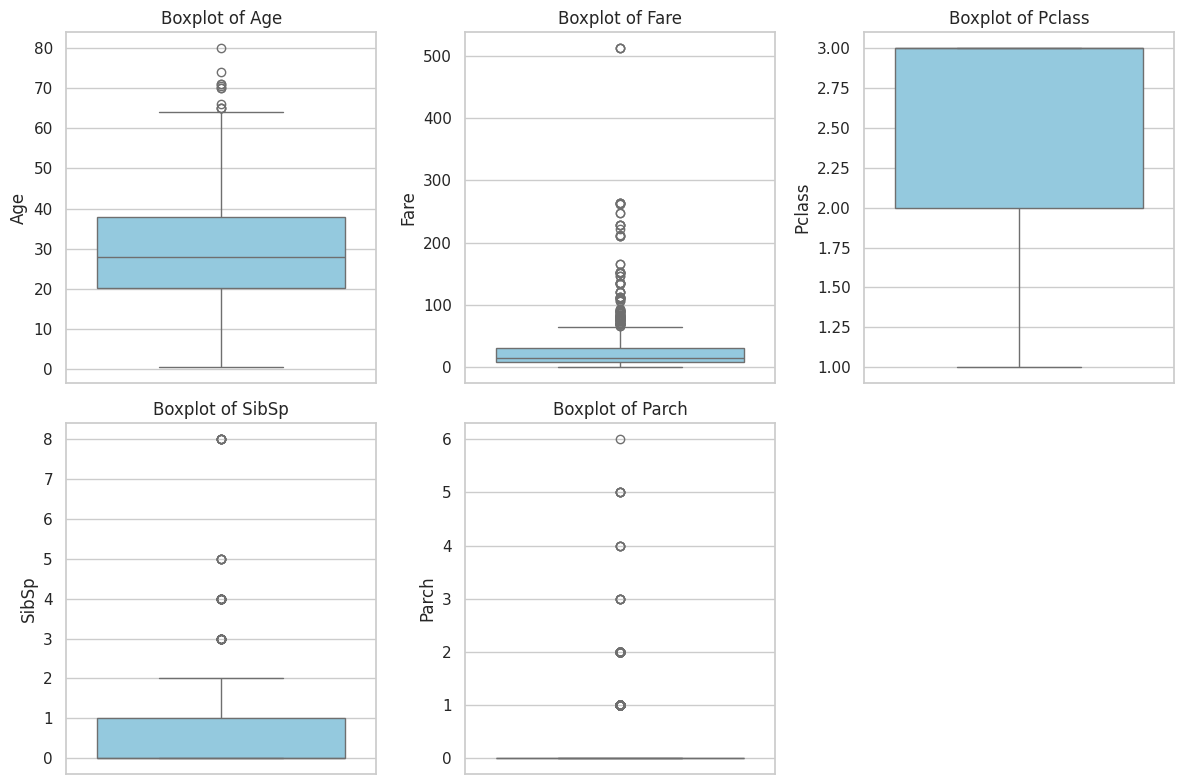

In [ ]:
#Boxplot
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=train_df[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

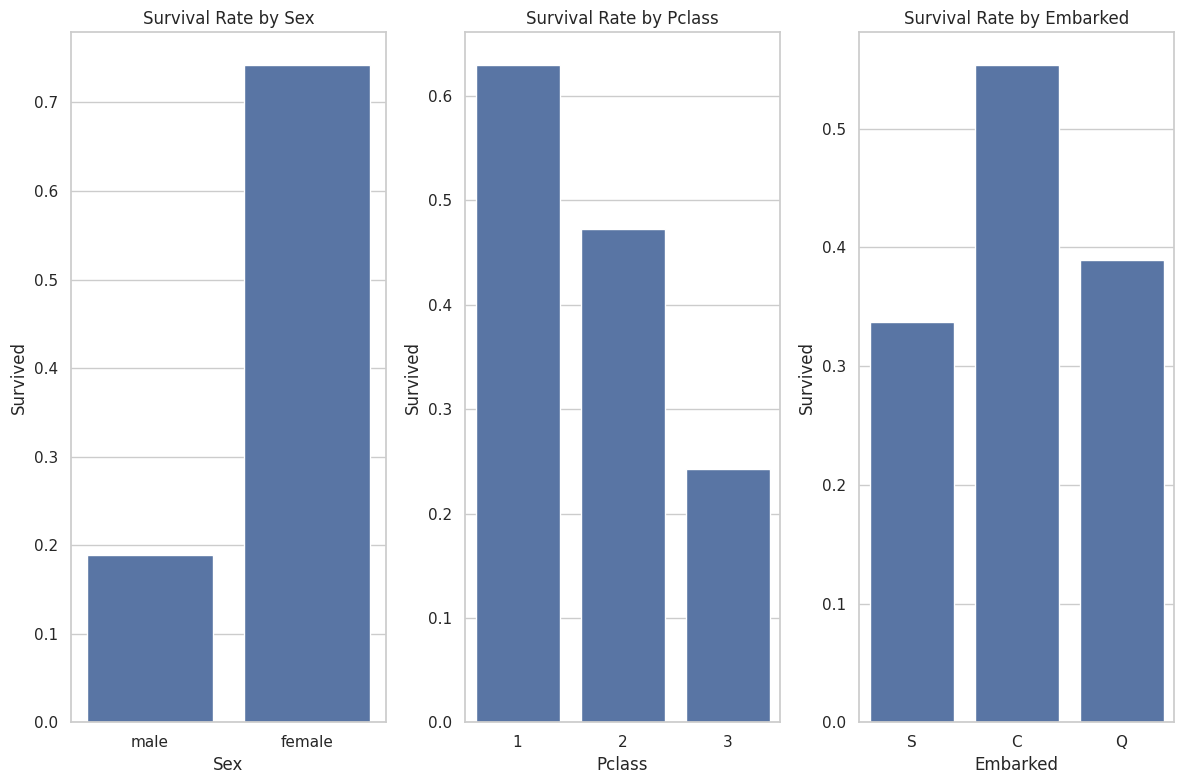

In [ ]:
#Bar plot
categorical_cols = ['Sex', 'Pclass', 'Embarked']
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_cols):
    plt.subplot(1, 3, i+1)
    sns.barplot(data=train_df, x=col, y='Survived', errorbar=None)
    plt.title(f'Survival Rate by {col}')
plt.tight_layout()
plt.show()

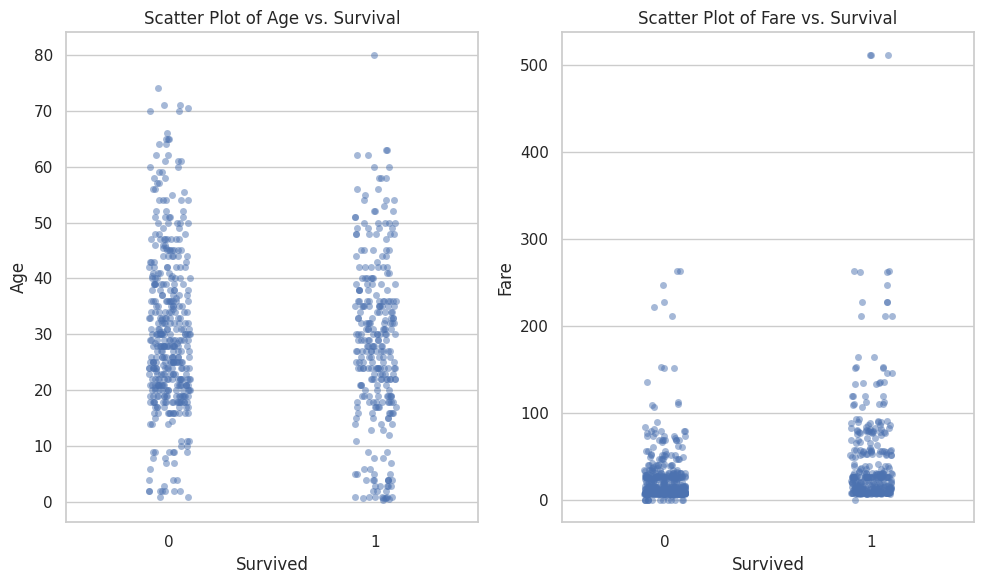

In [ ]:
#Scatter Plot
plt.figure(figsize=(10, 6))

plt.subplot(1,2,1)
sns.stripplot(data=train_df, x='Survived', y='Age', jitter=True, alpha=0.5)
plt.title('Scatter Plot of Age vs. Survival')

plt.subplot(1,2,2)
sns.stripplot(data=train_df, x='Survived', y='Fare', jitter=True, alpha=0.5)
plt.title('Scatter Plot of Fare vs. Survival')

plt.tight_layout()
plt.show()

**Data Preprocessing:**

In [ ]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
train_df['Fare'] = train_df['Fare'].fillna(train_df['Fare'].median())

if 'Embarked' in train_df.columns:
    train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])


In [ ]:
train_df.drop(columns=['Cabin'], inplace=True, errors='ignore')

In [ ]:
#Label Encode 'Sex'
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['Sex'] = label_encoder.fit_transform(train_df['Sex'])

#One-Hot Encode
train_df = pd.get_dummies(train_df, columns=['Embarked','Pclass'], drop_first=True)

In [ ]:
#Feature Engineering
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1

train_df.drop(columns=['Name', 'Ticket'], inplace=True, errors='ignore')
print(train_df.head())

   PassengerId  Survived  Sex   Age  SibSp  Parch     Fare  Embarked_Q  \
0            1         0    1  22.0      1      0   7.2500       False   
1            2         1    0  38.0      1      0  71.2833       False   
2            3         1    0  26.0      0      0   7.9250       False   
3            4         1    0  35.0      1      0  53.1000       False   
4            5         0    1  35.0      0      0   8.0500       False   

   Embarked_S  Pclass_2  Pclass_3  FamilySize  
0        True     False      True           2  
1       False     False     False           2  
2        True     False      True           1  
3        True     False     False           2  
4        True     False      True           1  


**Building Predictive Models:**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb

X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
selector = VarianceThreshold(threshold=0.0)
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if y_pred.ndim > 1 or not set(np.unique(y_pred)).issubset({0, 1}):
         y_pred = (y_pred > 0.5).astype(int)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

lgb_model = lgb.LGBMClassifier(random_state=42,verbose=-1)
lgb_model.fit(X_train, y_train)
print("\n--- Light Evaluation ---")
evaluate_model(lgb_model, X_test, y_test)

xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
print("\n--- XGB Evaluation ---")
evaluate_model(xgb_model, X_test, y_test)

param_grid = {
    'num_leaves':[15,31,50],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(random_state=42),
                          param_grid= param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Parameters (LightGBM):", grid_search.best_params_)

print("\n ---Tuned LIGHTGBM Evaluation ---")
evaluate_model(grid_search.best_estimator_, X_test, y_test)


--- Light Evaluation ---
Accuracy: 0.8100558659217877
Precision: 0.7857142857142857
Recall: 0.7432432432432432
F1 Score: 0.7638888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84       105
           1       0.79      0.74      0.76        74

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179


--- XGB Evaluation ---
Accuracy: 0.8044692737430168
Precision: 0.7910447761194029
Recall: 0.7162162162162162
F1 Score: 0.75177304964539

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       105
           1       0.79      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

Fitting 5 folds fo

**Comparative Analysis:**

1.	Compare the performance metrics (e.g., accuracy, precision, recall) of LightGBM and XGBoost models.

* **LightGBM(Default) -** Best overall performance with highest accuracy and recall. More balanced in handling both classes. F1 score is also the highest, indicating good balance between precision and recall.

* **XGBoost(Default) -** Slightly lower on all metrics. Performs reasonably well but underperforms compared to LightGBM. Could benefit from hyperparameter tuning.

* **LightGBM(Tuned) -** Highest precision better at reducing false positives. Slight tradeoff in recall, which means it may miss more actual positives.



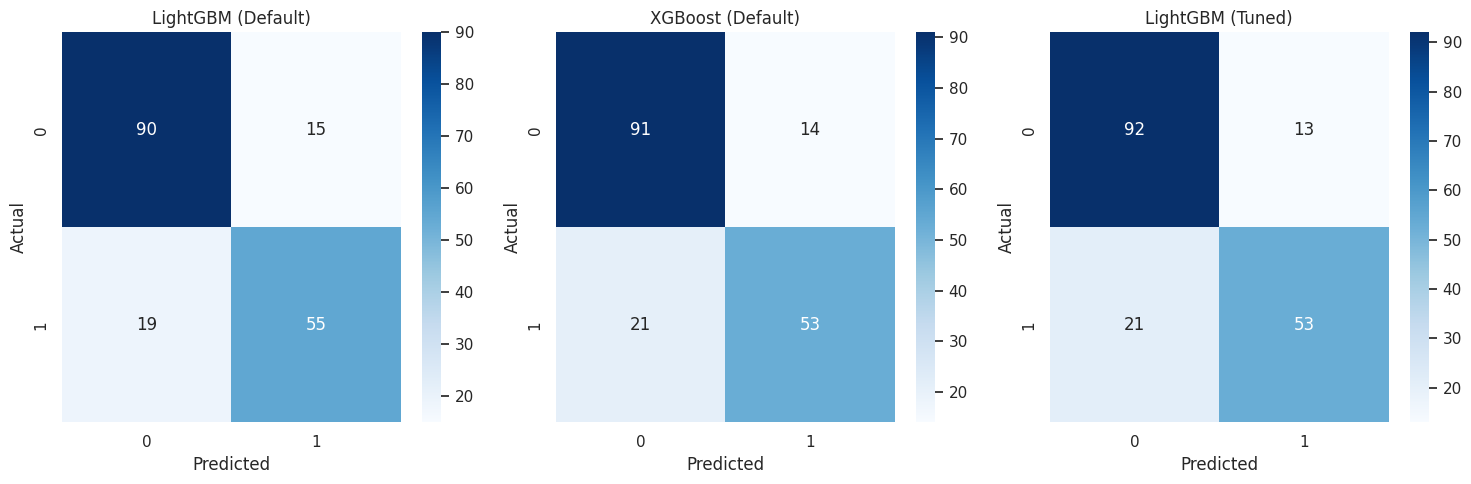

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_lgb = lgb_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lgb_tuned = grid_search.best_estimator_.predict(X_test)

cm_lgb = confusion_matrix(y_test, y_pred_lgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_lgb_tuned = confusion_matrix(y_test, y_pred_lgb_tuned)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('LightGBM (Default)')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('XGBoost (Default)')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

sns.heatmap(cm_lgb_tuned, annot=True, fmt='d', cmap='Blues', ax=axs[2])
axs[2].set_title('LightGBM (Tuned)')
axs[2].set_xlabel('Predicted')
axs[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

**Interpretation:**
* A higher number of true positives and true negatives indicates better model performance.
* If your model has more false negative, it's missing actual survivors.
* If there are more false positives, it's predicting too many survivors wrongly.

**LightGBM(Default)**

Strength - High precision and balance in TP/TN.

Weakness - Some missed actual survivors(FN=18).

**XGBoost(Default)**

Strength - Slightly conservative (fewer FP).

Weakness - More false negatives.

**LightBGM(Tuned)**

Strength - Improved TN/FP ration.

Weakness - Higher FN -> lower recall.

